In [2]:
import json
import numpy as np
from math import log
import pandas as pd
import os

# Load configuration
with open("../../config/config_notebooks_TNBC_with_HER2_model.json", "r") as config_file:
    config = json.load(config_file)


In [3]:
name = "HER2_uni_full_koleo_16384_prototypes"

invasive_path = os.path.join(config['retrained_benchmark_folder2'], 
                                  "invasive_cancer_clustering",
                                   "kmeans")

In [4]:
optimal_clusters = pd.read_csv(os.path.join(invasive_path, "optimal_clusters.csv"), index_col=0)


In [5]:
import glob

filename = glob.glob(os.path.join(invasive_path,
                                    name, 
                                    f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
df = pd.read_csv(filename, index_col=0)

In [6]:
metadata = pd.read_excel("/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/ST_TNBC_metadata.xlsx")

In [11]:
# Extract patient IDs from the spot names in df
# Assuming spot names have format like "TNBC78_1x2" where "TNBC78" is the patient ID
df['patient_id'] = df.index.str.split('_').str[0]

# Count spots per cluster per patient
cluster_counts = df.groupby(['patient_id', 'predicted_label']).size().reset_index(name='count')

# Calculate total spots per patient
total_spots = df.groupby('patient_id').size().reset_index(name='total')

# Merge and calculate percentages
cluster_composition = cluster_counts.merge(total_spots, on='patient_id')
cluster_composition['percentage'] = (cluster_composition['count'] / cluster_composition['total']) * 100

# Pivot to get one row per patient with columns for each cluster
cluster_composition_wide = cluster_composition.pivot(
    index='patient_id', 
    columns='predicted_label', 
    values='percentage'
).fillna(0)

# Rename columns to be more descriptive
cluster_composition_wide.columns = [f'cluster_{col}_pct' for col in cluster_composition_wide.columns]

print(f"Cluster composition for {len(cluster_composition_wide)} patients:")
cluster_composition_wide

Cluster composition for 85 patients:


,cluster_0_pct,cluster_1_pct,cluster_2_pct,cluster_3_pct,cluster_4_pct,cluster_5_pct,cluster_6_pct
patient_id,,,,,,,
TNBC1,3.067485,38.036810,34.969325,0.000000,13.496933,8.588957,1.840491
TNBC11,40.041494,4.979253,11.203320,0.000000,10.373444,5.809129,27.593361
TNBC12,3.157895,18.947368,29.473684,0.000000,29.473684,4.210526,14.736842
TNBC13,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000
TNBC14,3.311258,18.101545,24.834437,0.000000,45.695364,4.304636,3.752759
...,...,...,...,...,...,...,...
TNBC92,19.709702,13.750955,6.493506,0.000000,49.197861,0.840336,10.007639
TNBC93,78.448753,8.254848,0.720222,0.110803,9.916898,0.277008,2.271468
TNBC94,6.987952,12.530120,0.642570,46.907631,2.409639,0.000000,30.522088


In [12]:
# Merge cluster composition with clinical metadata
# First, match patient IDs between cluster data and metadata
metadata['patient_id'] = metadata['ST_TNBC_ID'].apply(lambda x: f"TNBC{x}")  # Adjust column name if needed



Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct', 'cluster_5_pct', 'cluster_6_pct']


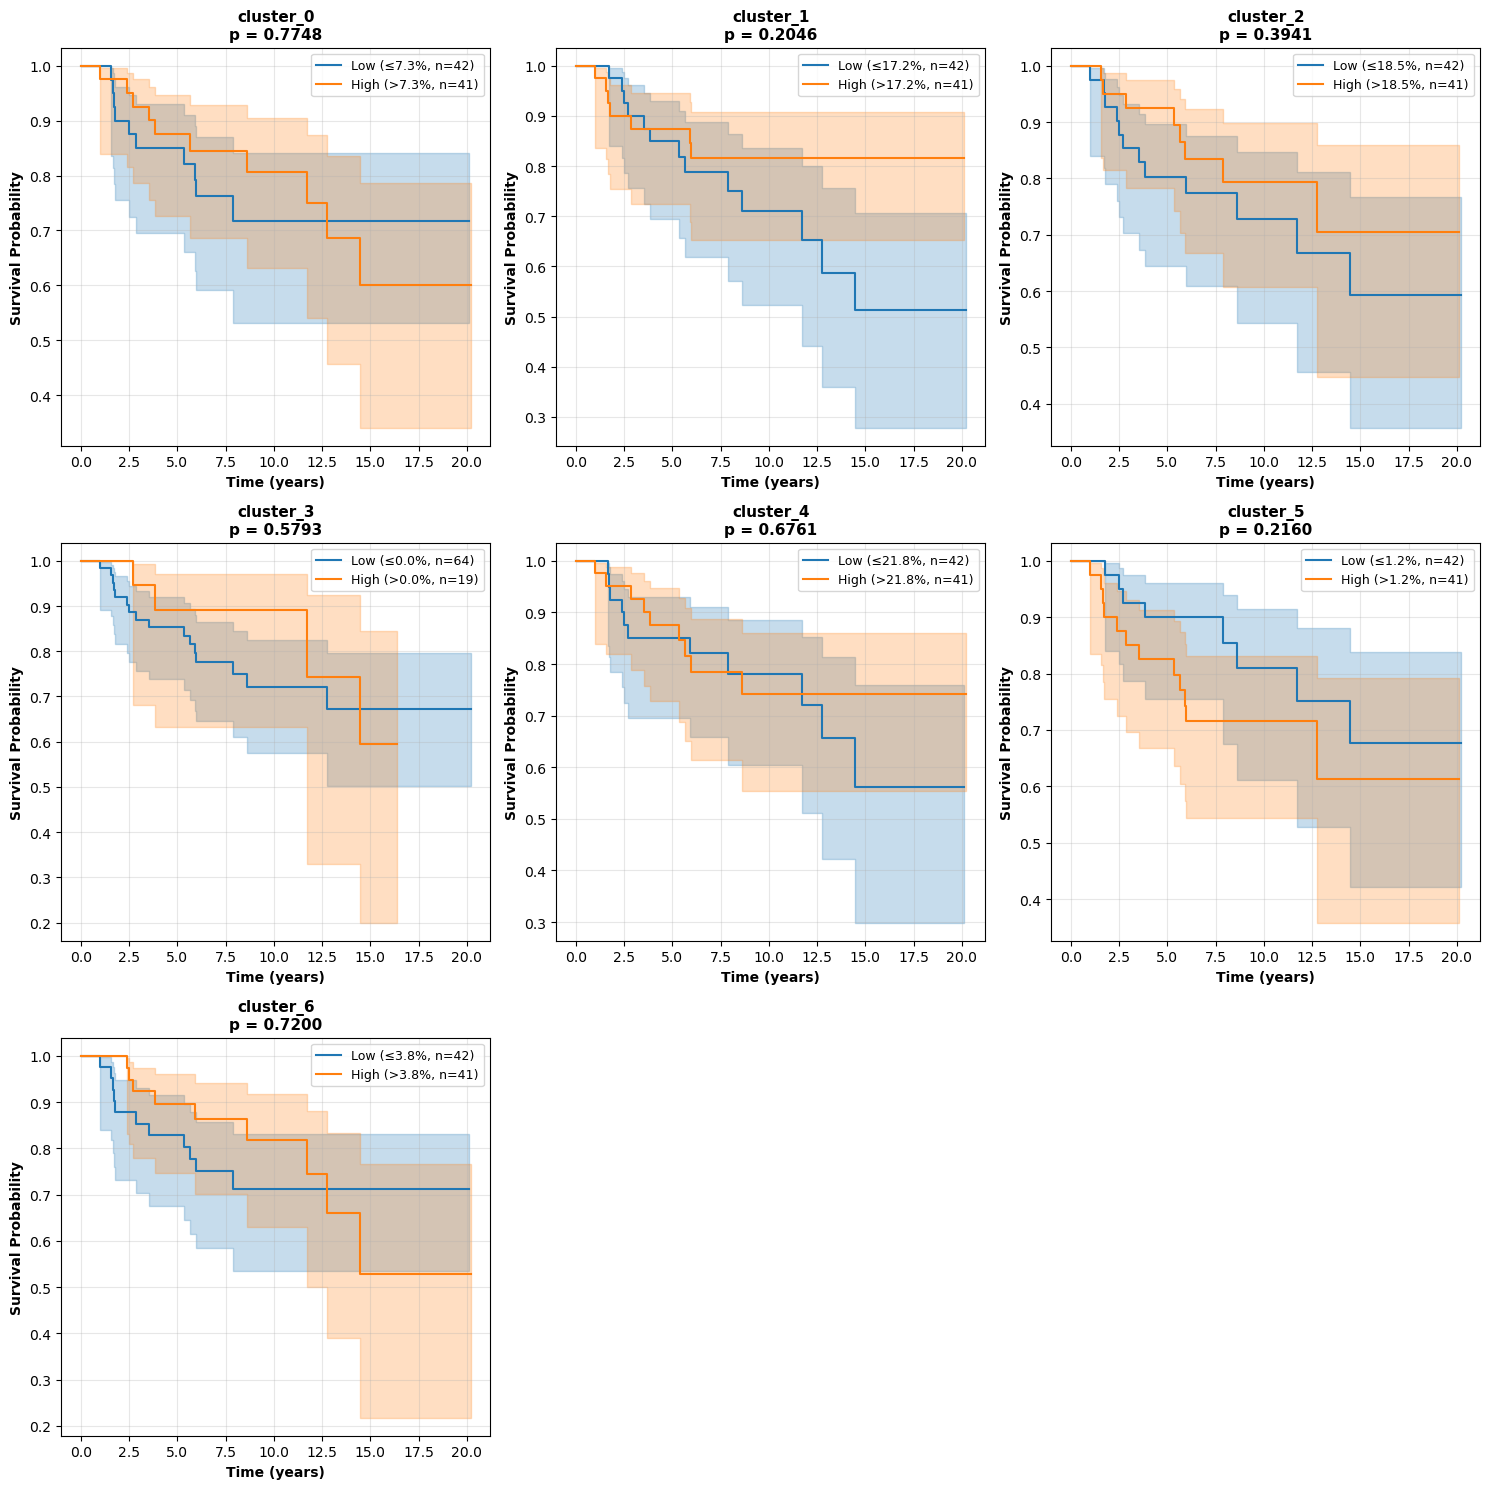


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,7.299270,42,41,0.774802,0.081853
1,cluster_1,17.169374,42,41,0.204568,1.609456
2,cluster_2,18.506835,42,41,0.394140,0.726132
3,cluster_3,0.000000,64,19,0.579306,0.307357
4,cluster_4,21.751412,42,41,0.676096,0.174554
5,cluster_5,1.160093,42,41,0.215968,1.530960
6,cluster_6,3.806735,42,41,0.719969,0.128522


In [13]:
# Create groups based on cluster composition
# Strategy: For each cluster, divide patients into high vs low percentage groups using median split

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'OS_years', 'OS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['OS_years', 'OS-event', cluster_col]].dropna()
    
    # Split by median
    median_val = data_clean[cluster_col].median()
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > median_val]
    low_group = data_clean[data_clean[cluster_col] <= median_val]
    
    # Plot low group
    kmf.fit(low_group['OS_years'], 
            low_group['OS-event'], 
            label=f'Low (≤{median_val:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['OS_years'], 
            high_group['OS-event'], 
            label=f'High (>{median_val:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['OS_years'], 
        high_group['OS_years'],
        event_observed_A=low_group['OS-event'],
        event_observed_B=high_group['OS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df

Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct', 'cluster_5_pct', 'cluster_6_pct']


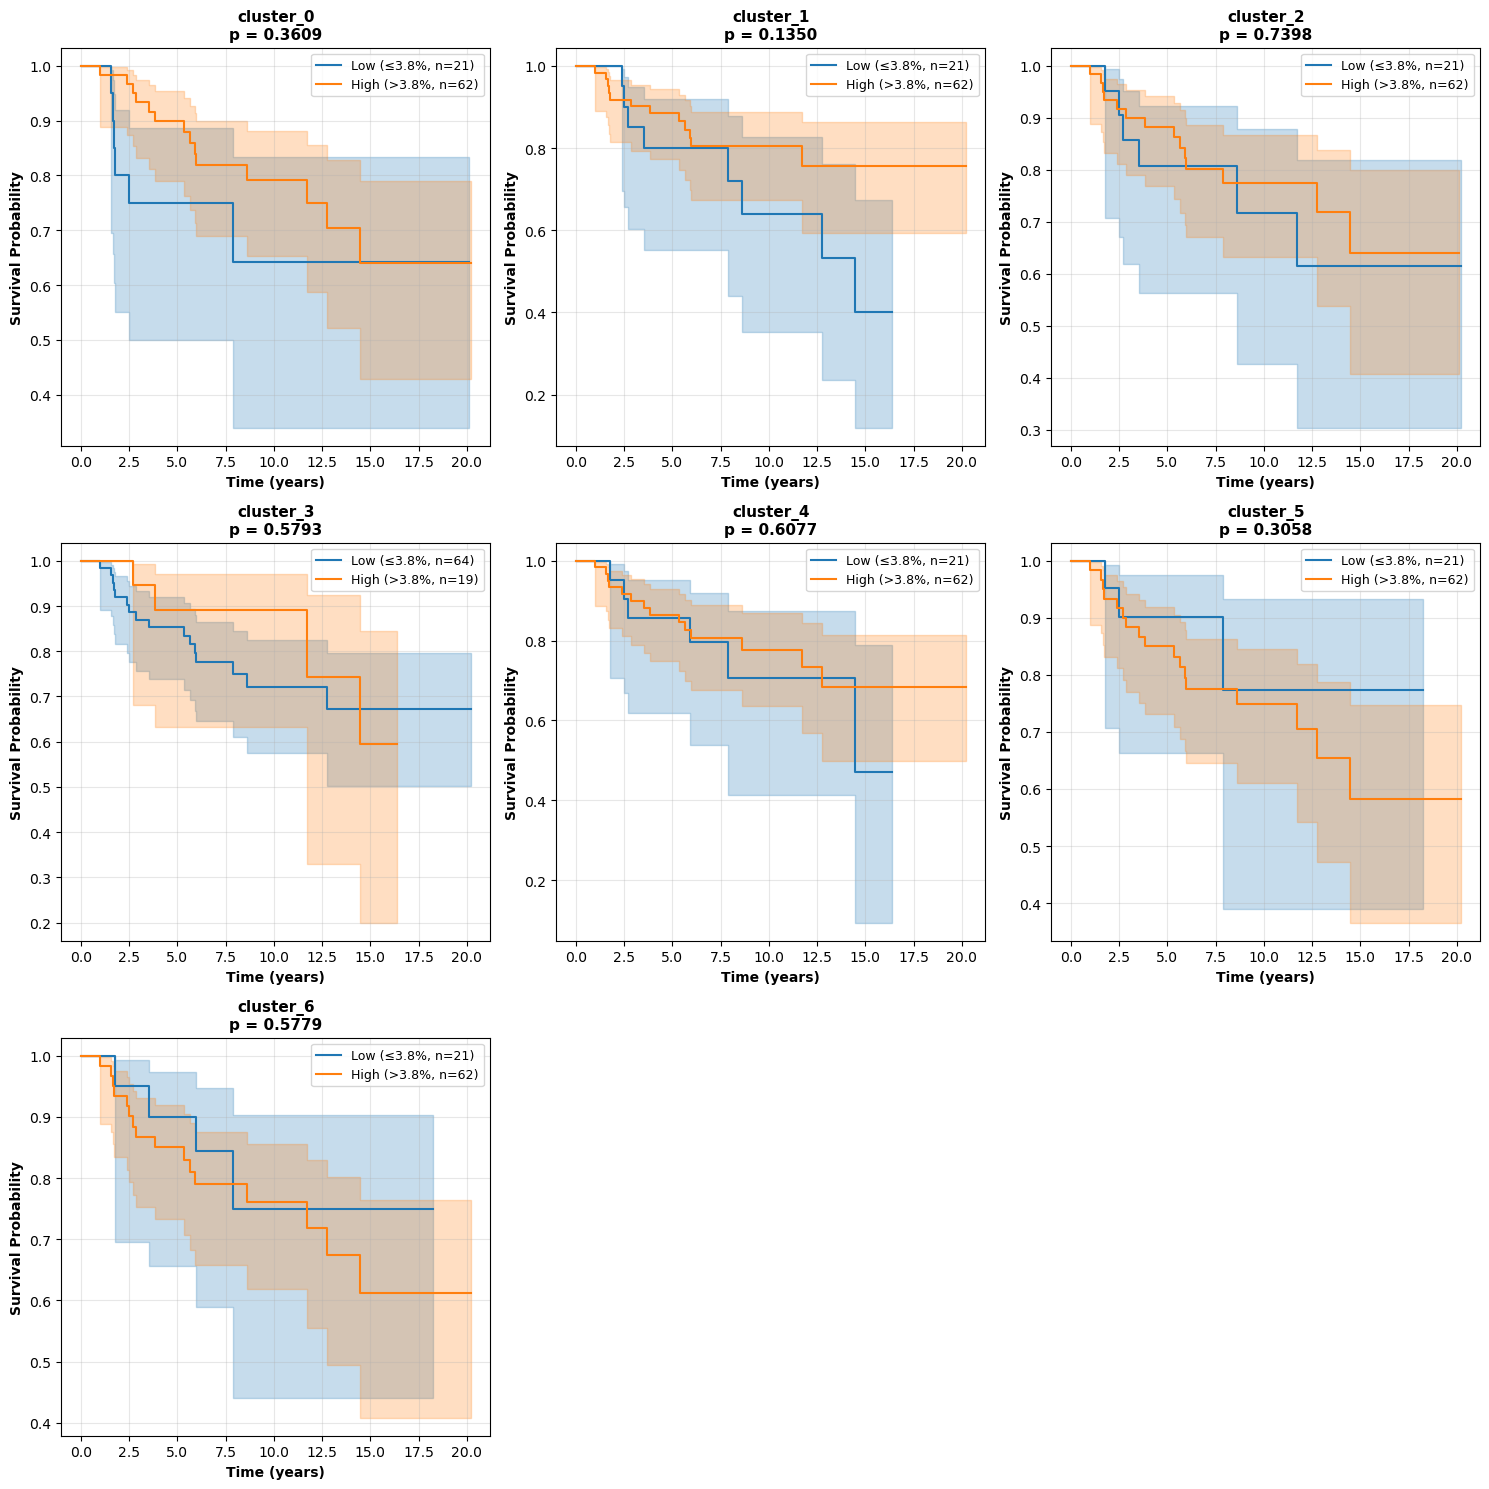


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,3.806735,21,62,0.360906,0.834739
1,cluster_1,3.806735,21,62,0.135028,2.233721
2,cluster_2,3.806735,21,62,0.739805,0.110298
3,cluster_3,3.806735,64,19,0.579306,0.307357
4,cluster_4,3.806735,21,62,0.607700,0.263538
5,cluster_5,3.806735,21,62,0.305771,1.048854
6,cluster_6,3.806735,21,62,0.577864,0.309700


In [14]:

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'OS_years', 'OS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['OS_years', 'OS-event', cluster_col]].dropna()
    
    # Split by median
    third_quartile = data_clean[cluster_col].quantile(0.25)
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > third_quartile]
    low_group = data_clean[data_clean[cluster_col] <= third_quartile]
    
    # Plot low group
    kmf.fit(low_group['OS_years'], 
            low_group['OS-event'], 
            label=f'Low (≤{median_val:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['OS_years'], 
            high_group['OS-event'], 
            label=f'High (>{median_val:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['OS_years'], 
        high_group['OS_years'],
        event_observed_A=low_group['OS-event'],
        event_observed_B=high_group['OS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df

In [15]:
# Highlight significant clusters (p < 0.05)
significant_clusters = results_df[results_df['p_value'] < 0.05].sort_values('p_value')

if len(significant_clusters) > 0:
    print(f"\n⭐ Significant clusters (p < 0.05):")
    print(significant_clusters)
else:
    print("\nNo clusters showed significant association with survival (p < 0.05)")


No clusters showed significant association with survival (p < 0.05)


In [16]:
metadata['iBCFS-event']

0     0.0
1     0.0
2     1.0
3     0.0
4     1.0
     ... 
89    1.0
90    0.0
91    0.0
92    0.0
93    0.0
Name: iBCFS-event, Length: 94, dtype: float64

Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct', 'cluster_5_pct', 'cluster_6_pct']


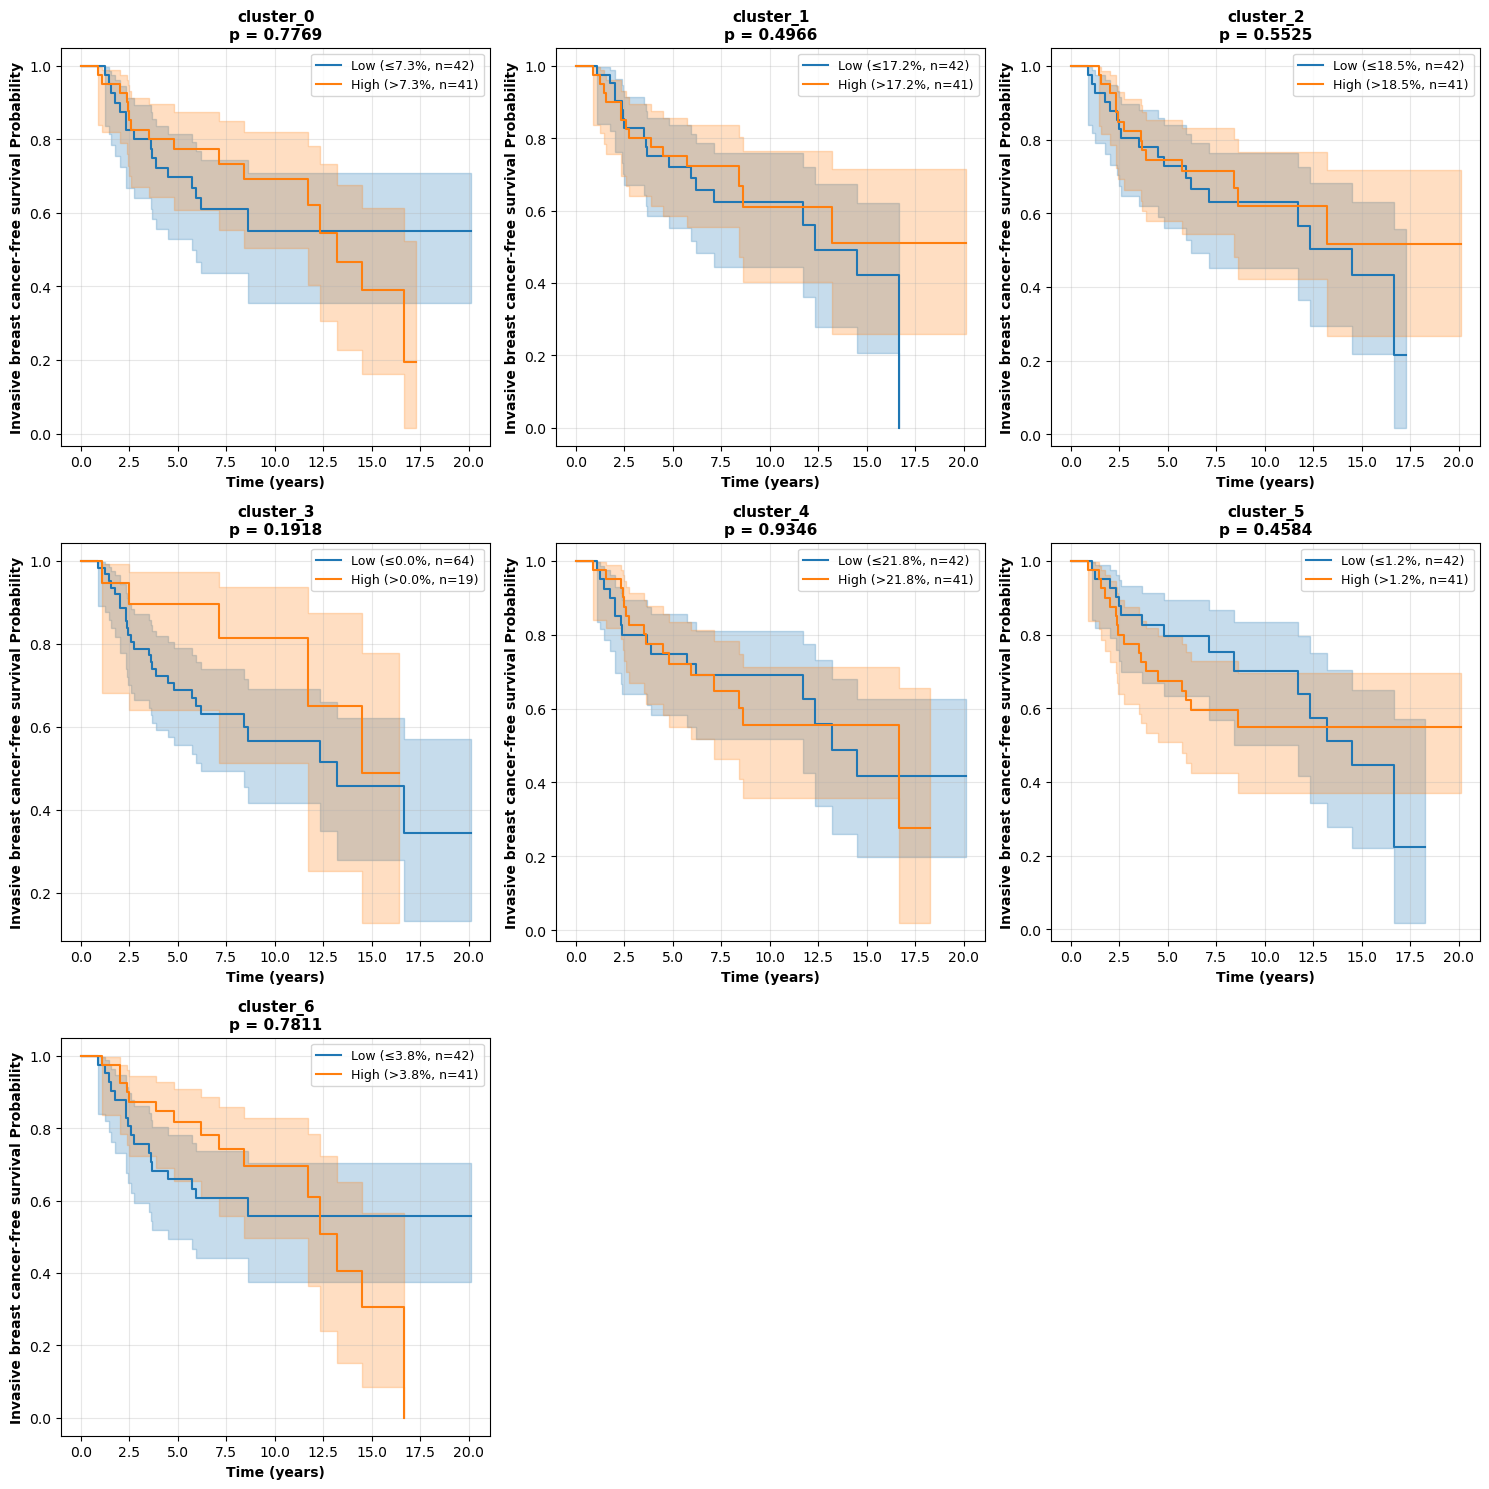


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,7.299270,42,41,0.776915,0.080282
1,cluster_1,17.169374,42,41,0.496627,0.462138
2,cluster_2,18.506835,42,41,0.552464,0.352922
3,cluster_3,0.000000,64,19,0.191838,1.703443
4,cluster_4,21.751412,42,41,0.934588,0.006736
5,cluster_5,1.160093,42,41,0.458402,0.549793
6,cluster_6,3.806735,42,41,0.781080,0.077235


In [17]:
# Create groups based on cluster composition
# Strategy: For each cluster, divide patients into high vs low percentage groups using median split

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'iBCFS_years', 'iBCFS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['iBCFS_years', 'iBCFS-event', cluster_col]].dropna()
    
    # Split by median
    median_val = data_clean[cluster_col].median()
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > median_val]
    low_group = data_clean[data_clean[cluster_col] <= median_val]
    
    # Plot low group
    kmf.fit(low_group['iBCFS_years'], 
            low_group['iBCFS-event'], 
            label=f'Low (≤{median_val:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['iBCFS_years'], 
            high_group['iBCFS-event'], 
            label=f'High (>{median_val:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['iBCFS_years'], 
        high_group['iBCFS_years'],
        event_observed_A=low_group['iBCFS-event'],
        event_observed_B=high_group['iBCFS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Invasive breast cancer-free survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df

Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct', 'cluster_5_pct', 'cluster_6_pct']


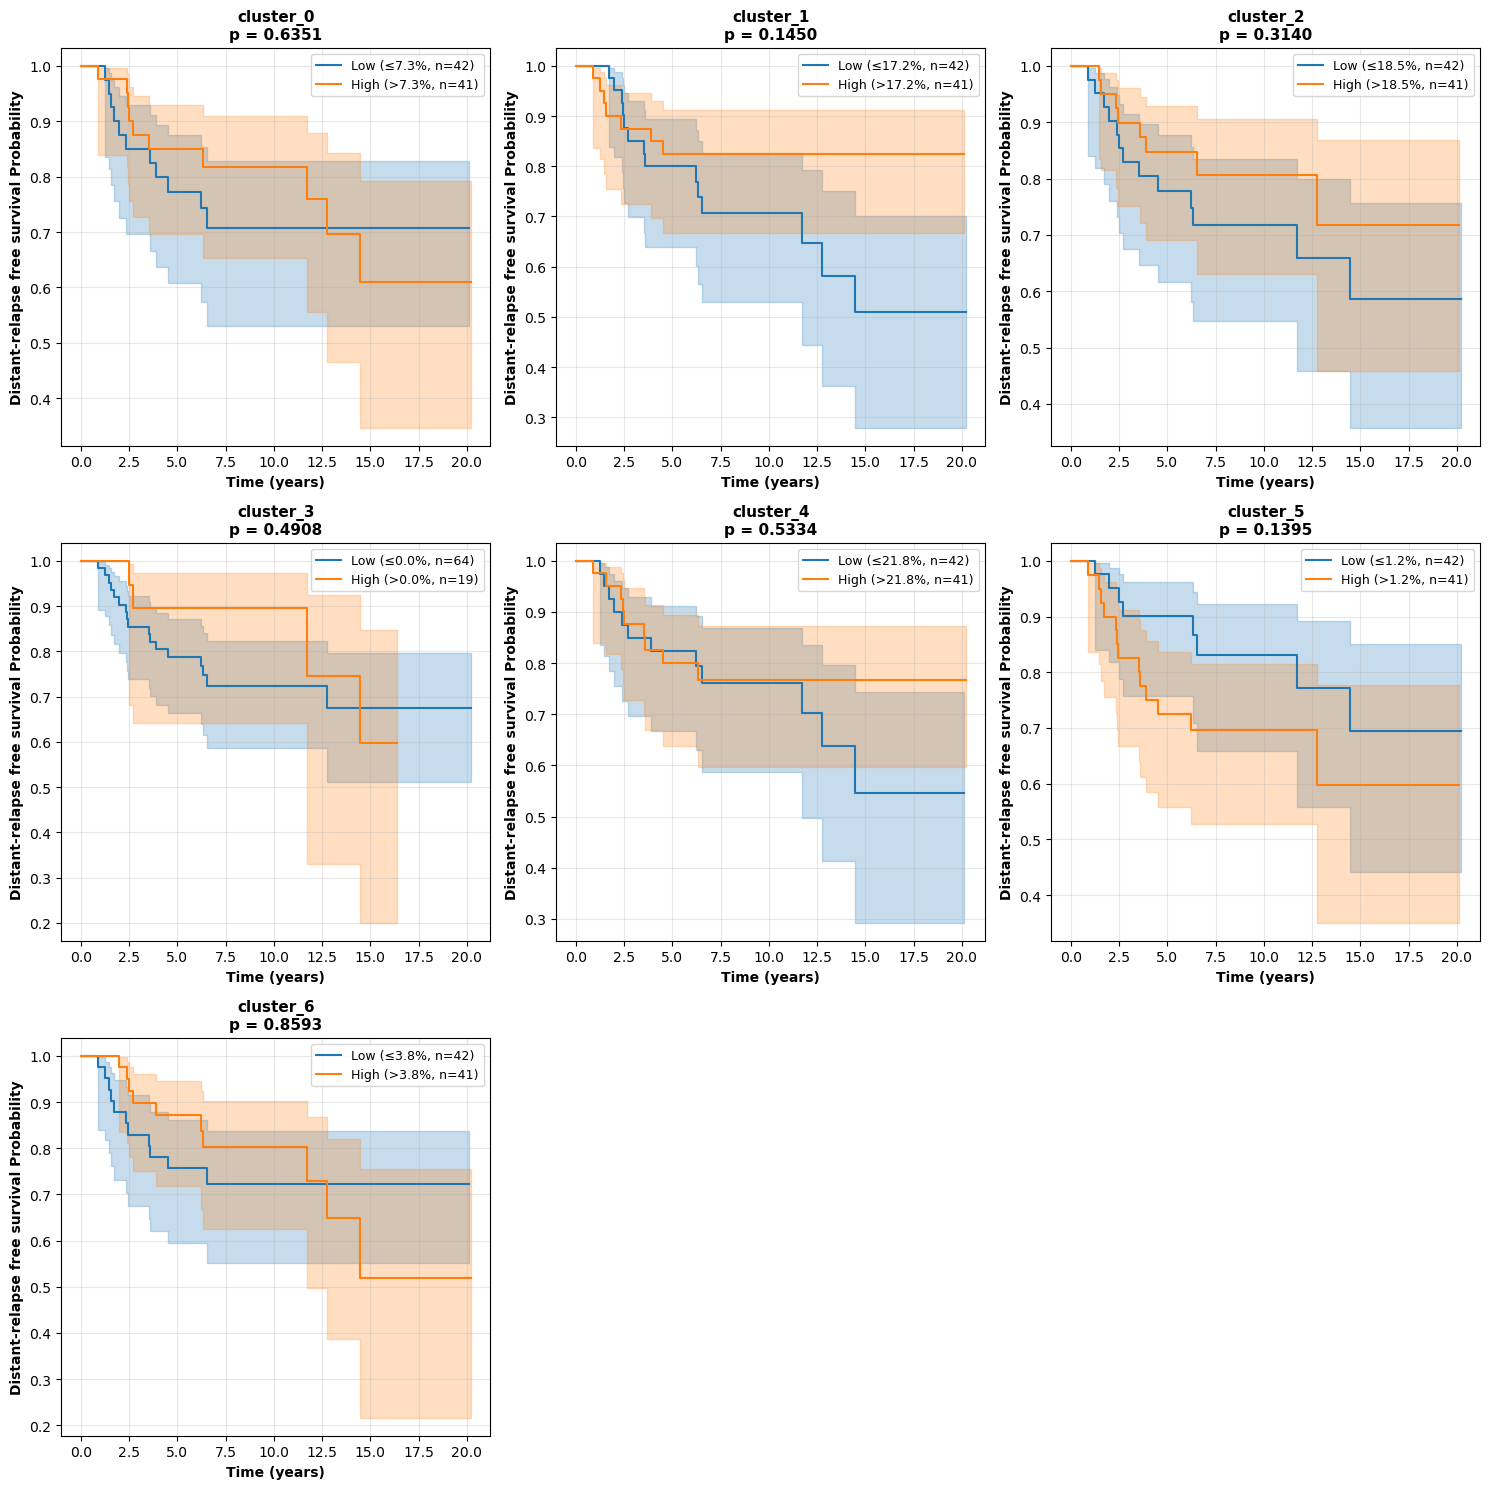


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,7.299270,42,41,0.635140,0.225155
1,cluster_1,17.169374,42,41,0.145017,2.123899
2,cluster_2,18.506835,42,41,0.313975,1.013881
3,cluster_3,0.000000,64,19,0.490841,0.474683
4,cluster_4,21.751412,42,41,0.533380,0.387948
5,cluster_5,1.160093,42,41,0.139541,2.183014
6,cluster_6,3.806735,42,41,0.859321,0.031413


In [18]:
# Create groups based on cluster composition
# Strategy: For each cluster, divide patients into high vs low percentage groups using median split

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'DRFS_years', 'DRFS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['DRFS_years', 'DRFS-event', cluster_col]].dropna()
    
    # Split by median
    median_val = data_clean[cluster_col].median()
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > median_val]
    low_group = data_clean[data_clean[cluster_col] <= median_val]
    
    # Plot low group
    kmf.fit(low_group['DRFS_years'], 
            low_group['DRFS-event'], 
            label=f'Low (≤{median_val:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['DRFS_years'], 
            high_group['DRFS-event'], 
            label=f'High (>{median_val:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['DRFS_years'], 
        high_group['DRFS_years'],
        event_observed_A=low_group['DRFS-event'],
        event_observed_B=high_group['DRFS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Distant-relapse free survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df

Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct', 'cluster_5_pct', 'cluster_6_pct']


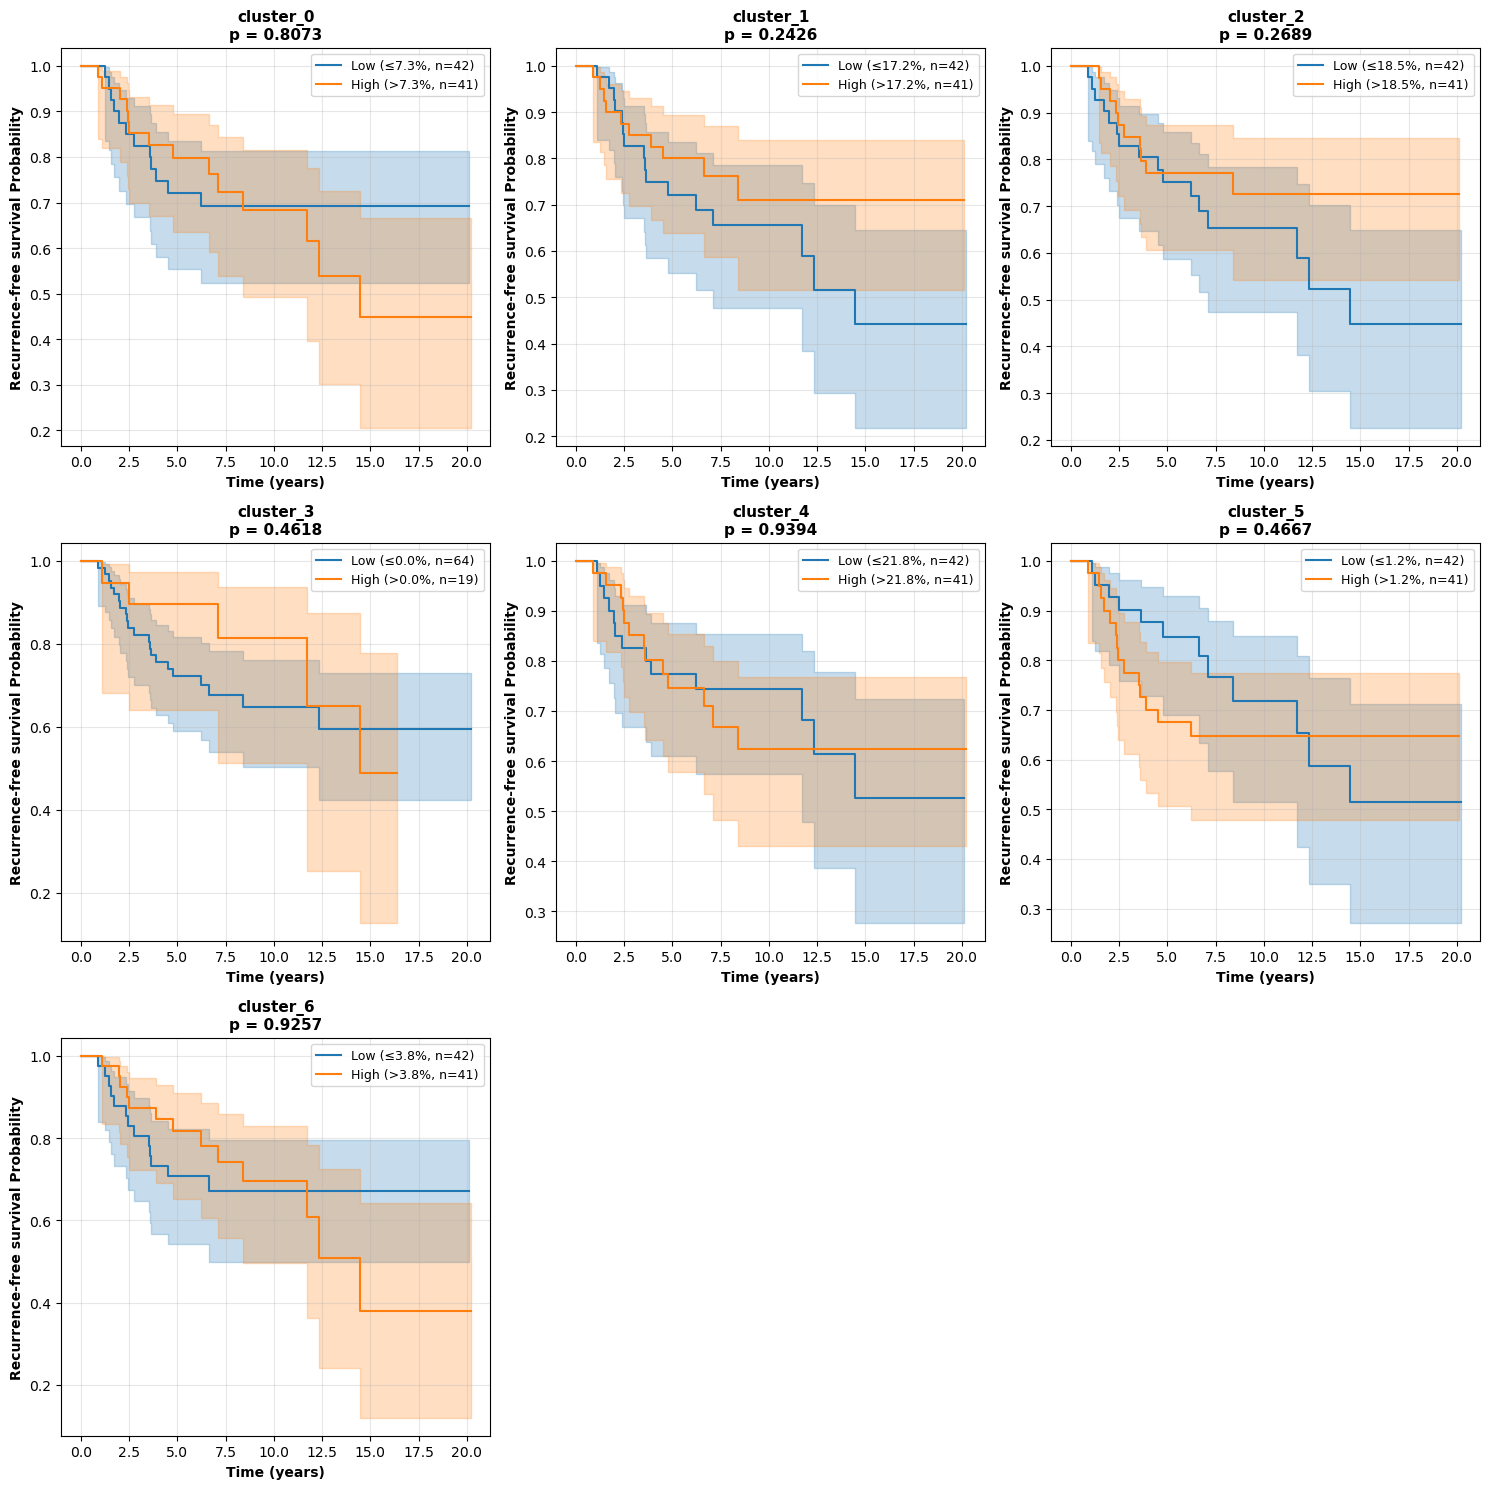


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,7.299270,42,41,0.807328,0.059475
1,cluster_1,17.169374,42,41,0.242565,1.365623
2,cluster_2,18.506835,42,41,0.268929,1.222201
3,cluster_3,0.000000,64,19,0.461843,0.541425
4,cluster_4,21.751412,42,41,0.939369,0.005786
5,cluster_5,1.160093,42,41,0.466747,0.529668
6,cluster_6,3.806735,42,41,0.925672,0.008703


In [19]:
# Create groups based on cluster composition
# Strategy: For each cluster, divide patients into high vs low percentage groups using median split

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'RFS_years', 'RFS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['RFS_years', 'RFS-event', cluster_col]].dropna()
    
    # Split by median
    median_val = data_clean[cluster_col].median()
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > median_val]
    low_group = data_clean[data_clean[cluster_col] <= median_val]
    
    # Plot low group
    kmf.fit(low_group['RFS_years'], 
            low_group['RFS-event'], 
            label=f'Low (≤{median_val:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['RFS_years'], 
            high_group['RFS-event'], 
            label=f'High (>{median_val:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['RFS_years'], 
        high_group['RFS_years'],
        event_observed_A=low_group['RFS-event'],
        event_observed_B=high_group['RFS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Recurrence-free survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df

Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct', 'cluster_5_pct', 'cluster_6_pct']


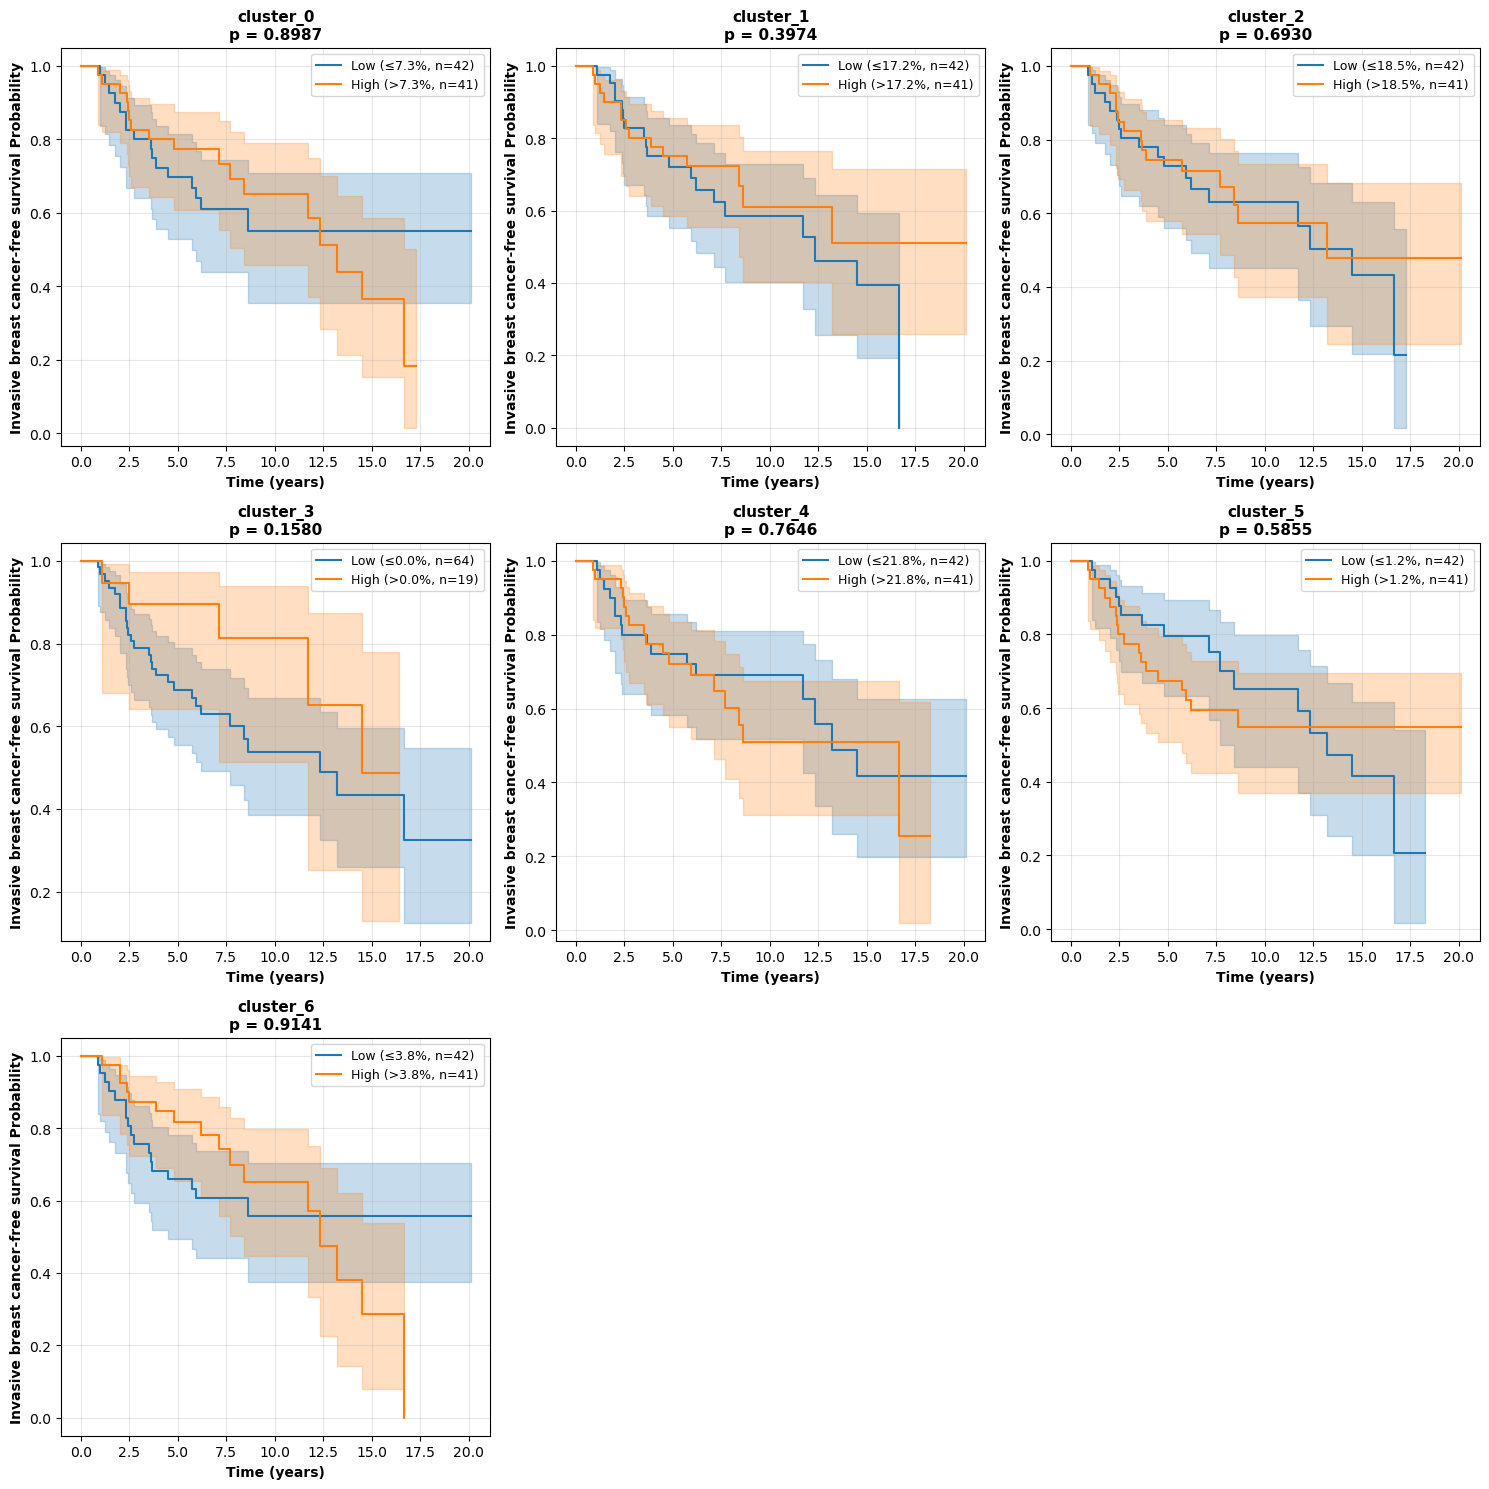


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,7.299270,42,41,0.898706,0.016204
1,cluster_1,17.169374,42,41,0.397428,0.716095
2,cluster_2,18.506835,42,41,0.692973,0.155886
3,cluster_3,0.000000,64,19,0.157975,1.993502
4,cluster_4,21.751412,42,41,0.764626,0.089647
5,cluster_5,1.160093,42,41,0.585526,0.297385
6,cluster_6,3.806735,42,41,0.914067,0.011645


In [20]:
# Create groups based on cluster composition
# Strategy: For each cluster, divide patients into high vs low percentage groups using median split

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'iDFS_years', 'iDFS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['iDFS_years', 'iDFS-event', cluster_col]].dropna()
    
    # Split by median
    median_val = data_clean[cluster_col].median()
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > median_val]
    low_group = data_clean[data_clean[cluster_col] <= median_val]
    
    # Plot low group
    kmf.fit(low_group['iDFS_years'], 
            low_group['iDFS-event'], 
            label=f'Low (≤{median_val:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['iDFS_years'], 
            high_group['iDFS-event'], 
            label=f'High (>{median_val:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['iDFS_years'], 
        high_group['iDFS_years'],
        event_observed_A=low_group['iDFS-event'],
        event_observed_B=high_group['iDFS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Invasive breast cancer-free survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df